In [1]:
import os
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import pickle

from FiberPredictor import FiberPredictor
from skimage.feature import hog


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [37]:
def get_img(image_directory):
    image = Image.open(image_directory)
    image = image.convert('L')
    return image
    
def get_feature_vector(image, grid_q= 4, no_orientation= 8):
    if type(grid_q)== np.ndarray: # ndarray path
        hog_features= []
        for gq in grid_q:
            hf= get_feature_vector(image, grid_q= gq, no_orientation= no_orientation)
            hog_features= np.append(hog_features, hf)
    else: # integer path
        ppc= (image.size[0]//grid_q, image.size[1]//grid_q)
        hog_features= hog(image, orientations= no_orientation, pixels_per_cell= ppc,
                        cells_per_block=(1, 1), feature_vector= True)
    return hog_features

GRIDQ = np.arange(1, 6)
# GRIDQ = np.arange(1, 4)
ORIENTATION = 10

def build_model(X_train, y_train):
    model = FiberPredictor()
    model = model.train_model(X_train, y_train)
    return model


In [38]:
def augment_data(img, label, img_dir, img_directories, feature_matrix, labels):
    # Rotations
    for i in range(1, 4):
        a_img = img.rotate(90*i)
        a_feature_vec = get_feature_vector(a_img, grid_q=GRIDQ, no_orientation=ORIENTATION)
        a_label = (label+90*i)%180
        img_directories.append(img_dir)
        feature_matrix.append(a_feature_vec)
        labels.append(a_label)
    # Flips
    a_img = ImageOps.mirror(img)
    a_feature_vec = get_feature_vector(a_img, grid_q=GRIDQ, no_orientation=ORIENTATION)
    a_label = (180-label)%180
    img_directories.append(img_dir)
    feature_matrix.append(a_feature_vec)
    labels.append(a_label)
    
    a_img = ImageOps.flip(img)
    a_feature_vec = get_feature_vector(a_img, grid_q=GRIDQ, no_orientation=ORIENTATION)
    a_label = (180-label)%180
    img_directories.append(img_dir)
    feature_matrix.append(a_feature_vec)
    labels.append(a_label)
    
    a_img = ImageOps.mirror(ImageOps.flip(img))
    a_feature_vec = get_feature_vector(a_img, grid_q=GRIDQ, no_orientation=ORIENTATION)
    a_label = label
    img_directories.append(img_dir)
    feature_matrix.append(a_feature_vec)
    labels.append(a_label)

def get_data(file_dir, csv_dir, i_start=1, augment=False):
    bio_csv= np.loadtxt(csv_dir)

    feature_matrix= []
    img_directories= []
    labels= []

    for index, label in enumerate(bio_csv):
        if not np.isnan(label):
            img_dir = file_dir + str(index + i_start) + ".png"
            img = get_img(img_dir)

            feature_vec = get_feature_vector(img, grid_q=GRIDQ, no_orientation=ORIENTATION)
            
            img_directories.append(img_dir)
            feature_matrix.append(feature_vec)
            labels.append(label)

            if augment:
                augment_data(img, label, img_dir, img_directories, feature_matrix, labels)

    feature_matrix= np.array(feature_matrix)
    labels= np.array(labels)
    img_directories= np.array(img_directories)
    return feature_matrix, labels, img_directories


Total picture/label count: 673/673


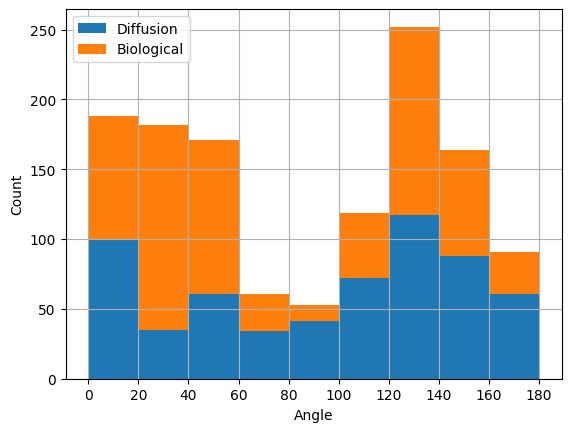

In [39]:
file_dir= "images/bio/"
csv_dir= "images/bio/labels.csv"

bio_feature_matrix, bio_labels, bio_img_directories= get_data(file_dir, csv_dir)
print(f"Total picture/label count: {bio_img_directories.size}/{bio_labels.size}")

file_dir= "images/diffusion/diffusion_voxels/"
csv_dir= "images/diffusion/diffusion_voxels/labels.csv"

diff_feature_matrix, diff_labels, diff_img_directories= get_data(file_dir, csv_dir, 2001)

plt.figure()
plt.hist([diff_labels, bio_labels], bins= np.arange(0, 181, 20), stacked= True, align="mid")

plt.xticks(np.arange(0, 181, 20))
plt.ylabel("Count")
plt.xlabel("Angle")
plt.legend(["Diffusion", "Biological"])
plt.grid()

In [40]:
print(f"Biological picture/label count: {bio_feature_matrix.shape[0]}/{bio_labels.size}")

EPOCH= 100
model_list= []
mae_list= []

for i in range(EPOCH):
  X_train, X_test, y_train, y_test= train_test_split(bio_feature_matrix, bio_labels, test_size= .3)
  model= build_model(X_train, y_train)

  y_pred= model.predict(X_test)

  mae= mean_absolute_error(y_test, y_pred)

  model_list.append(model)
  mae_list.append(mae)
  # print(f"EPOCH {i+1}| Mean Absolute Error: {mae:.3f}")

best_model= model_list[mae_list.index(min(mae_list))]
print(f"Best Model MAE: {min(mae_list) :.2f} | Mean MAE: {sum(mae_list)/EPOCH :.2f}")

# Save the model
with open("./pickles/bio_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)
    
print("*"*50)
mae_b2b= mean_absolute_error(y_test, best_model.predict(X_test))
print(f"Train: bio_train_random => Predict: bio_test_random | MAE: {mae_b2b :.2f}")

mae_b2d= mean_absolute_error(diff_labels, best_model.predict(diff_feature_matrix))
print(f"Train: bio => Predict: diff | MAE: {mae_b2d :.2f}")

Biological picture/label count: 673/673
Best Model MAE: 10.77 | Mean MAE: 13.39
**************************************************
Train: bio_train_random => Predict: bio_test_random | MAE: 12.70
Train: bio => Predict: diff | MAE: 12.26


In [ ]:
print(f"Diffusion picture/label count: {diff_feature_matrix.shape[0]}/{diff_labels.size}")

EPOCH= 100
model_list= []
mae_list= []

for i in range(EPOCH):
  X_train, X_test, y_train, y_test= train_test_split(diff_feature_matrix, diff_labels, test_size= .3)
  model= build_model(X_train, y_train)

  y_pred= model.predict(X_test)

  mae= mean_absolute_error(y_test, y_pred)

  model_list.append(model)
  mae_list.append(mae)
  # print(f"EPOCH {i+1}| Mean Absolute Error: {mae:.3f}")

best_model= model_list[mae_list.index(min(mae_list))]
print(f"Best Model MAE: {min(mae_list) :.2f} | Mean MAE: {sum(mae_list)/EPOCH :.2f}")

# Save the model
with open("./pickles/diff_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)

print("*"*50)
mae_d2d= mean_absolute_error(y_test, best_model.predict(X_test))
print(f"Train: diff_train_random => Predict: diff_test_random | MAE: {mae_d2d :.2f}")

mae_d2b= mean_absolute_error(bio_labels, best_model.predict(bio_feature_matrix))
print(f"Train: diff => Predict: bio | MAE: {mae_d2b :.2f}")

In [ ]:
combined_feature_matrix= np.append(bio_feature_matrix, diff_feature_matrix, axis= 0)
combined_labels= np.append(bio_labels, diff_labels)
print(f"Combined picture/label count: {combined_feature_matrix.shape[0]}/{combined_labels.size}")

EPOCH= 100
model_list= []
mae_list= []

for i in range(EPOCH):
  X_train, X_test, y_train, y_test= train_test_split(combined_feature_matrix, combined_labels, test_size= .3)
  model= build_model(X_train, y_train)

  y_pred= model.predict(X_test)

  mae= mean_absolute_error(y_test, y_pred)

  model_list.append(model)
  mae_list.append(mae)
  # print(f"EPOCH {i+1}| Mean Absolute Error: {mae:.3f}")

best_model= model_list[mae_list.index(min(mae_list))]
print(f"Best Model MAE: {min(mae_list) :.2f} | Mean MAE: {sum(mae_list)/EPOCH :.2f}")

# Save the model
with open("./pickles/combined_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)


print("*"*50)
mae_c2c= mean_absolute_error(y_test, best_model.predict(X_test))
print(f"Train: comb_train_random => Predict: comb_test_random | MAE: {mae_c2c :.2f}")

mae_c2b= mean_absolute_error(bio_labels, best_model.predict(bio_feature_matrix))
print(f"Train: comb => Predict: bio | MAE: {mae_c2b :.2f}")

mae_c2d= mean_absolute_error(diff_labels, best_model.predict(diff_feature_matrix))
print(f"Train: comb => Predict: diff | MAE: {mae_c2d :.2f}")

## Augmented Models


In [ ]:
file_dir= "images/bio/"
csv_dir= "images/bio/labels.csv"

bio_feature_matrix, bio_labels, bio_img_directories= get_data(file_dir, csv_dir, augment=True)
print(f"Total picture/label count: {bio_img_directories.size}/{bio_labels.size}")

file_dir= "images/diffusion/diffusion_voxels/"
csv_dir= "images/diffusion/diffusion_voxels/labels.csv"

diff_feature_matrix, diff_labels, diff_img_directories= get_data(file_dir, csv_dir, 2001)

In [ ]:
# Create a mask to filter the data
mask = np.zeros(bio_labels.shape, dtype=bool)

angle_range = 5
for angle in range(0, 181, angle_range):
    indices = np.where((bio_labels >= angle) & (bio_labels < angle + angle_range))[0]
    np.random.shuffle(indices)
    mask[indices[:30]] = True

# Apply the mask to the feature matrix, labels, and image directories
bio_feature_matrix = bio_feature_matrix[mask]
bio_labels = bio_labels[mask]
bio_img_directories = bio_img_directories[mask]


In [ ]:
print(f"Total sampled picture/label count: {bio_img_directories.size}/{bio_labels.size}")
plt.hist(bio_labels, bins=180//angle_range)
plt.xticks(np.arange(0, 181, 20))

plt.figure()
plt.hist([diff_labels, bio_labels], bins= np.arange(0, 181, 20), stacked= True, align="mid")

plt.xticks(np.arange(0, 181, 20))
plt.ylabel("Count")
plt.xlabel("Angle")
plt.legend(["Diffusion", "Biological"])
plt.grid()


In [ ]:
print(f"Biological picture/label count: {bio_feature_matrix.shape[0]}/{bio_labels.size}")

EPOCH= 100
model_list= []
mae_list= []

for i in range(EPOCH):
  X_train, X_test, y_train, y_test= train_test_split(bio_feature_matrix, bio_labels, test_size= .3)
  model= build_model(X_train, y_train)

  y_pred= model.predict(X_test)

  mae= mean_absolute_error(y_test, y_pred)

  model_list.append(model)
  mae_list.append(mae)
  # print(f"EPOCH {i+1}| Mean Absolute Error: {mae:.3f}")

best_model= model_list[mae_list.index(min(mae_list))]
print(f"Best Model MAE: {min(mae_list) :.2f} | Mean MAE: {sum(mae_list)/EPOCH :.2f}")

# Save the model
with open("./pickles/A_bio_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)
    
print("*"*50)
mae_b2b= mean_absolute_error(y_test, best_model.predict(X_test))
print(f"Train: bio_train_random => Predict: bio_test_random | MAE: {mae_b2b :.2f}")

mae_b2d= mean_absolute_error(diff_labels, best_model.predict(diff_feature_matrix))
print(f"Train: bio => Predict: diff | MAE: {mae_b2d :.2f}")

In [ ]:
print(f"Diffusion picture/label count: {diff_feature_matrix.shape[0]}/{diff_labels.size}")

EPOCH= 100
model_list= []
mae_list= []

for i in range(EPOCH):
  X_train, X_test, y_train, y_test= train_test_split(diff_feature_matrix, diff_labels, test_size= .3)
  model= build_model(X_train, y_train)

  y_pred= model.predict(X_test)

  mae= mean_absolute_error(y_test, y_pred)

  model_list.append(model)
  mae_list.append(mae)
  # print(f"EPOCH {i+1}| Mean Absolute Error: {mae:.3f}")

best_model= model_list[mae_list.index(min(mae_list))]
print(f"Best Model MAE: {min(mae_list) :.2f} | Mean MAE: {sum(mae_list)/EPOCH :.2f}")

# Save the model
with open("./pickles/A_diff_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)

print("*"*50)
mae_d2d= mean_absolute_error(y_test, best_model.predict(X_test))
print(f"Train: diff_train_random => Predict: diff_test_random | MAE: {mae_d2d :.2f}")

mae_d2b= mean_absolute_error(bio_labels, best_model.predict(bio_feature_matrix))
print(f"Train: diff => Predict: bio | MAE: {mae_d2b :.2f}")

In [ ]:
combined_feature_matrix= np.append(bio_feature_matrix, diff_feature_matrix, axis= 0)
combined_labels= np.append(bio_labels, diff_labels)
print(f"Combined picture/label count: {combined_feature_matrix.shape[0]}/{combined_labels.size}")

EPOCH= 100
model_list= []
mae_list= []

for i in range(EPOCH):
  X_train, X_test, y_train, y_test= train_test_split(combined_feature_matrix, combined_labels, test_size= .3)
  model= build_model(X_train, y_train)

  y_pred= model.predict(X_test)

  mae= mean_absolute_error(y_test, y_pred)

  model_list.append(model)
  mae_list.append(mae)
  # print(f"EPOCH {i+1}| Mean Absolute Error: {mae:.3f}")

best_model= model_list[mae_list.index(min(mae_list))]
print(f"Best Model MAE: {min(mae_list) :.2f} | Mean MAE: {sum(mae_list)/EPOCH :.2f}")

# Save the model
with open("./pickles/A_combined_model.pkl", 'wb') as f:
    pickle.dump(best_model, f)


print("*"*50)
mae_c2c= mean_absolute_error(y_test, best_model.predict(X_test))
print(f"Train: comb_train_random => Predict: comb_test_random | MAE: {mae_c2c :.2f}")

mae_c2b= mean_absolute_error(bio_labels, best_model.predict(bio_feature_matrix))
print(f"Train: comb => Predict: bio | MAE: {mae_c2b :.2f}")

mae_c2d= mean_absolute_error(diff_labels, best_model.predict(diff_feature_matrix))
print(f"Train: comb => Predict: diff | MAE: {mae_c2d :.2f}")